# Week 4 Lab: Neural Networks in practice

In [ ]:
# Global imports and settings

from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import keras
print("Using Keras",keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides
import seaborn as sns
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


Using Keras 2.2.5


### Overview
* Solving basic classification and regression problems
* Handling textual data
* Model selection (and overfitting)

## Solving basic problems
* Binary classification (of movie reviews)
* Multiclass classification (of news topics)
* Regression (of house prices)

Examples from _Deep Learning with Python_, by _François Chollet_

### Binary classification
* Dataset: 50,000 IMDB reviews, labeled positive (1) or negative (0)
    - Included in Keras, with a 50/50 train-test split
* Each row is one review, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [ ]:
from keras.datasets import imdb
# Download IMDB data with 10000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Encoded review: ", train_data[0][0:10])

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original review: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]][0:10]))

17465344/17464789 [==============================] - 0s 0us/step
Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
1646592/1641221 [==============================] - 0s 0us/step
Original review:  ? this film was just brilliant casting location scenery story


#### Preprocessing
* We can't input lists of categorical value to a neural net, we need to create tensors
* One-hot-encoding:
    -  10000 features, '1.0' if the word occurs
* Word embeddings (word2vec):
    - Map each word to a dense vector that represents it (it's _embedding_)
    - _Embedding_ layer: pre-trained layer that looks up the embedding in a dictionary 
    - Converts 2D tensor of word indices (zero-padded) to 3D tensor of embeddings
* Let's do One-Hot-Encoding for now. We'll come back to _Embedding_ layers.
* Also vectorize the labels: from 0/1 to float
    - Binary classification works with one output node

In [ ]:
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#### Understanding the format of IMDB dataset
1. Train_data and test_data are an array of lists. What does the length of this array correspond to? What does the length of each list correspond to?
2. What are the sizes of the vectorized x_train and x_test? What do the dimensions correspond to?
3. What is the most common word in the first review in the training data? Hint: use the word index (see above)? 
4. Print the first review to verify. 

In [ ]:
# Answer1:
print(len(train_data))
print(len(test_data))

25000
25000


The length of this array corresponds to 25000 reviews in each of the dataset(test and train). The length of each list represents number of words present in every review.

In [ ]:
# Answer2:
print(x_train.size)
print(x_train.shape)
print(x_test.size)
print(x_test.shape)

250000000
(25000, 10000)
250000000
(25000, 10000)


The dimensions correspond to 25000 reviews and 10000 most frequently retained words(which means one-hot representation of the vocab list, if the word is present in the vocab list it is represented either as 0 or 1) for each review.

In [ ]:
#Answer 3:
counts = {}
for i in train_data[0]:
  if(i in counts):
    counts[i]+=1
  else:
    counts[i] = 1

In [ ]:
import operator
max(counts.items(), key=operator.itemgetter(1))

(4, 15)

In [ ]:
reverse_word_index[4 - 3]

'the'

In [ ]:
wordstring = [reverse_word_index.get(i - 3) for i in train_data[0]][1:219]
wordfreq = []
for w in wordstring:
    wordfreq.append(wordstring.count(w))

print("Pairs\n" + str(list(zip(wordstring, wordfreq))))

Pairs
[('this', 3), ('film', 6), ('was', 11), ('just', 4), ('brilliant', 3), ('casting', 1), ('location', 1), ('scenery', 1), ('story', 2), ('direction', 1), ("everyone's", 1), ('really', 2), ('suited', 1), ('the', 15), ('part', 1), ('they', 4), ('played', 2), ('and', 9), ('you', 4), ('could', 1), ('just', 4), ('imagine', 1), ('being', 2), ('there', 2), ('robert', 1), (None, 6), ('is', 1), ('an', 1), ('amazing', 3), ('actor', 1), ('and', 9), ('now', 1), ('the', 15), ('same', 2), ('being', 2), ('director', 1), (None, 6), ('father', 1), ('came', 1), ('from', 1), ('the', 15), ('same', 2), ('scottish', 1), ('island', 1), ('as', 3), ('myself', 1), ('so', 4), ('i', 3), ('loved', 1), ('the', 15), ('fact', 1), ('there', 2), ('was', 11), ('a', 3), ('real', 1), ('connection', 1), ('with', 2), ('this', 3), ('film', 6), ('the', 15), ('witty', 1), ('remarks', 1), ('throughout', 1), ('the', 15), ('film', 6), ('were', 2), ('great', 1), ('it', 6), ('was', 11), ('just', 4), ('brilliant', 3), ('so', 4),

The most commonly used word in the first review is "the", it is used 15 times. Which means the frequency of word "the" is 15.

In [ ]:
#Answer4:
print("First review is: \n", ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]]))

First review is: 
 ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have

#### Building the network
* We can solve this problem using a network of _Dense_ layers and the _ReLU_ activation function.
* How many layers? How many hidden units for layer?
    - Start with 2 layers of 16 hidden units each
    - We'll optimize this soon
* Output layer: single unit with _sigmoid_ activation function
    - Close to 1: positive review, close to 0: negative review
* Use binary_crossentropy loss

In [ ]:
from keras import models
from keras import layers 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Model selection
* How many epochs do we need for training?
* Take a validation set of 10,000 samples from the training set
* Train the neural net and track the loss after every iteration on the validation set
    - This is returned as a `History` object by the `fit()` function 
* We start with 20 epochs in minibatches of 512 samples


In [ ]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=2,
                    validation_data=(x_val, y_val))




Train on 15000 samples, validate on 10000 samples
Epoch 1/20





 - 2s - loss: 0.5502 - acc: 0.7805 - val_loss: 0.4141 - val_acc: 0.8616
Epoch 2/20
 - 1s - loss: 0.3323 - acc: 0.8961 - val_loss: 0.3387 - val_acc: 0.8643
Epoch 3/20
 - 1s - loss: 0.2405 - acc: 0.9234 - val_loss: 0.2822 - val_acc: 0.8928
Epoch 4/20
 - 1s - loss: 0.1866 - acc: 0.9391 - val_loss: 0.2760 - val_acc: 0.8914
Epoch 5/20
 - 1s - loss: 0.1539 - acc: 0.9499 - val_loss: 0.2762 - val_acc: 0.8905
Epoch 6/20
 - 1s - loss: 0.1206 - acc: 0.9637 - val_loss: 0.2941 - val_acc: 0.8854
Epoch 7/20
 - 1s - loss: 0.1031 - acc: 0.9698 - val_loss: 0.3409 - val_acc: 0.8716
Epoch 8/20
 - 1s - loss: 0.0859 - acc: 0.9755 - val_loss: 0.3213 - val_acc: 0.8819
Epoch 9/20
 - 1s - loss: 0.0701 - acc: 0.9825 - val_loss: 0.3417 - val_acc: 0.8794
Epoch 10/20
 - 1s - loss: 0.0583 - acc: 0.9856 - val_loss: 0.3631 - val_acc: 0.8786
Epoch 11/20
 - 1s - loss: 0.0459 - acc: 0.9904 - val_loss: 0.3881 - val_acc: 0.8777
Epoch 12/20
 - 1s - loss: 0

#### Evaluate model performance during training
1. Plot the training and validation loss as a function of training epoch. Describe what happens during the training in terms of under or overfitting.
2. Plot the training and validation accuracy as a function of the training epoch.

Hint: these quantities are contained in the dict history.history.

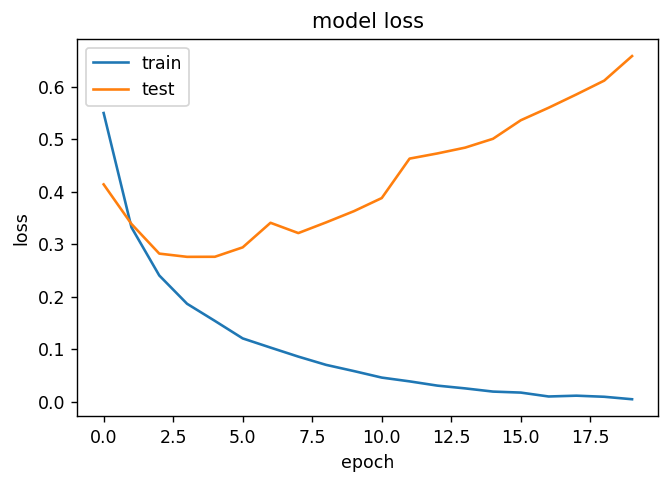

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As we can see from the training validation chart the model is overfitting. The training set is approach nearly perfect accuracy. This is not necessary a bad thing. Initially we want the model to overfitt. Overfitting it good in the sense that there are a lot of tools to tapper overfitting. At least the availablity of data is not the barrier.

In this case we can even use:

A even higher dropout rate, it seems that the neurons are still learning specific weights of some words/phrases. But when dropout rate is too high, the model does lose accuracy

Smaller batch size

Higher L2 regulization, similar effect to dropout

Overfitting it's a reflection of inefficiency in feature selection in this case, but as long as validation accuracy and testing accuracy are stable the model is a good shape.

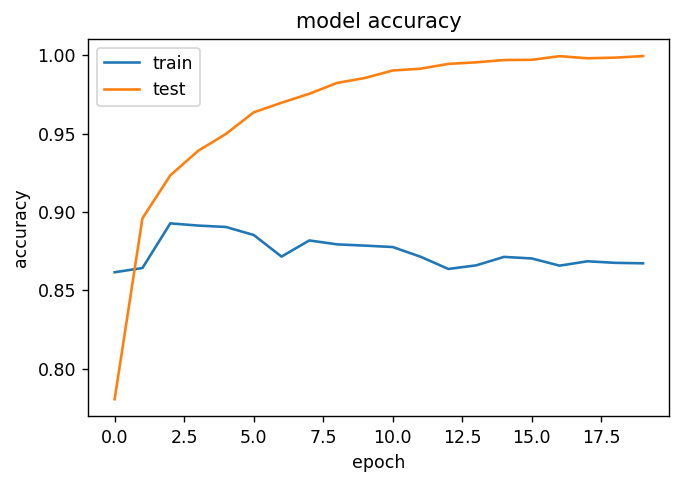

In [ ]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As per the result, I understood that the network begin to overfit as the epoches are increasing. Which means the model's train accuracy is increasing but the test accuracy or validation accuracy is decreasing with the increase in no.of epochs

#### Early stopping
One simple technique to avoid overfitting is to use the validation set to 'tune' the optimal number of epochs
* In this case, we could stop after 4 epochs


In [ ]:
#@title
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=2)
result = model.evaluate(x_test, y_test)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

Epoch 1/4
 - 1s - loss: 0.2258 - acc: 0.9450
Epoch 2/4
 - 1s - loss: 0.1377 - acc: 0.9595
Epoch 3/4
 - 1s - loss: 0.1067 - acc: 0.9686
Epoch 4/4
 - 1s - loss: 0.0836 - acc: 0.9761
25000/25000 [==============================] - 1s 53us/step
Loss: 0.4989, Accuracy:  0.8570


#### Predictions
1. Print the first review that were correctly classified along with the predicted value.
2. Print the first review that were misclassified along with the predicted value. Can you explain why the model likely failed? How confident was the model?

In [ ]:
predicted_classes = model.predict_classes(x_test).reshape(25000)
prediction_probabilities = model.predict(x_test)

In [ ]:
correctly_classified = test_labels == predicted_classes
mis_classified = test_labels != predicted_classes

correctly_classified_predictions = test_data[correctly_classified]
misclassified_predictions = test_data[mis_classified]
print(misclassified_predictions[0][0])

print(" ".join([reverse_word_index.get(i - 3, "?") for i in correctly_classified_predictions[0]]))
print('\n')
print(" ".join([reverse_word_index.get(i - 3, "?") for i in misclassified_predictions[0]]))

1
? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss


? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you

The model is faling because the words in the review are positive but the meaning seems to be sarcastic or negative.

#### Takeaways
* Neural nets require a lot of preprocessing to create tensors
* Dense layers with ReLU activation can solve a wide range of problems
* Binary classification can be done with a Dense layer with a single unit, sigmoid activation, and binary cross-entropy loss
* Neural nets overfit easily
* Many design choices have an effect on accuracy and overfitting. One can try:
    - 1 or 3 hidden layers
    - more or fewer hidden units (e.g. 64)
    - MSE loss instead of binary cross-entropy
    - `tanh` activation instead of `ReLU`

### Regularization: build smaller networks
* The easiest way to avoid overfitting is to use a simpler model
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - The entire training set can be `stored` in the weights
    - Learns the mapping from training examples to outputs
* Forcing the model to be small forces it to learn a compressed representation that generalizes better
    - Always a trade-off between too much and too little capacity
* Start with few layers and parameters, incease until you see diminisching returns

Let's try this on our movie review data, with 4 units per layer


In [ ]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512, verbose=2,
                                   validation_data=(x_test, y_test))
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512, verbose=2,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.4686 - acc: 0.8228 - val_loss: 0.3616 - val_acc: 0.8683
Epoch 2/20
 - 3s - loss: 0.2718 - acc: 0.9064 - val_loss: 0.2897 - val_acc: 0.8879
Epoch 3/20
 - 3s - loss: 0.2066 - acc: 0.9265 - val_loss: 0.2789 - val_acc: 0.8894
Epoch 4/20
 - 3s - loss: 0.1697 - acc: 0.9405 - val_loss: 0.2967 - val_acc: 0.8811
Epoch 5/20
 - 3s - loss: 0.1446 - acc: 0.9508 - val_loss: 0.3252 - val_acc: 0.8743
Epoch 6/20
 - 3s - loss: 0.1248 - acc: 0.9580 - val_loss: 0.3243 - val_acc: 0.8787
Epoch 7/20
 - 3s - loss: 0.1052 - acc: 0.9656 - val_loss: 0.3443 - val_acc: 0.8755
Epoch 8/20
 - 3s - loss: 0.0915 - acc: 0.9715 - val_loss: 0.3710 - val_acc: 0.8730
Epoch 9/20
 - 3s - loss: 0.0773 - acc: 0.9762 - val_loss: 0.3963 - val_acc: 0.8713
Epoch 10/20
 - 3s - loss: 0.0683 - acc: 0.9795 - val_loss: 0.4465 - val_acc: 0.8613
Epoch 11/20
 - 3s - loss: 0.0550 - acc: 0.9846 - val_loss: 0.4570 - val_acc: 0.8644
Epoch 12/20
 - 3s - loss: 0.0451 - 

1. Plot the validation loss for the original and smaller models. How does the smaller model behave compared to the original?

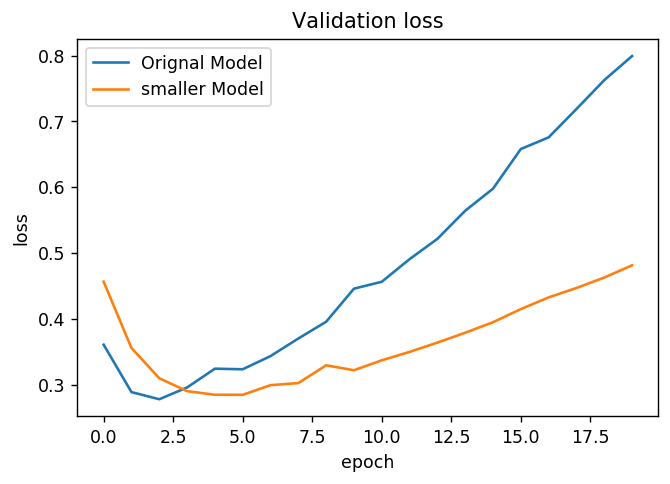

In [ ]:
plt.plot(original_hist.history['val_loss'])
plt.plot(smaller_model_hist.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Orignal Model', 'smaller Model'], loc='upper left')
plt.show()

Initially, the loss in the smaller model is higher than the loss in the original model. However, as the epochs are increasing the loss in the smaller model is less when compared to the loss in the original model. Which means the smaller model is less overfitting than the original model.

### Regularization: Weight regularization
* As we did many times before, we can also add weight regularization to our loss function
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights
    - Also called _weight decay_ in neural net literature
* In Keras, add `kernel_regularizer` to every layer

In [ ]:
from keras import regularizers
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [ ]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512, verbose=2,
                             validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.5124 - acc: 0.8089 - val_loss: 0.3897 - val_acc: 0.8777
Epoch 2/20
 - 3s - loss: 0.3217 - acc: 0.9040 - val_loss: 0.3535 - val_acc: 0.8774
Epoch 3/20
 - 3s - loss: 0.2727 - acc: 0.9198 - val_loss: 0.3397 - val_acc: 0.8822
Epoch 4/20
 - 3s - loss: 0.2498 - acc: 0.9286 - val_loss: 0.3424 - val_acc: 0.8830
Epoch 5/20
 - 3s - loss: 0.2367 - acc: 0.9334 - val_loss: 0.3423 - val_acc: 0.8844
Epoch 6/20
 - 3s - loss: 0.2296 - acc: 0.9367 - val_loss: 0.3752 - val_acc: 0.8731
Epoch 7/20
 - 3s - loss: 0.2217 - acc: 0.9389 - val_loss: 0.3602 - val_acc: 0.8777
Epoch 8/20
 - 3s - loss: 0.2168 - acc: 0.9416 - val_loss: 0.4255 - val_acc: 0.8581
Epoch 9/20
 - 3s - loss: 0.2145 - acc: 0.9425 - val_loss: 0.3732 - val_acc: 0.8767
Epoch 10/20
 - 3s - loss: 0.2089 - acc: 0.9445 - val_loss: 0.4452 - val_acc: 0.8528
Epoch 11/20
 - 3s - loss: 0.2070 - acc: 0.9440 - val_loss: 0.3826 - val_acc: 0.8746
Epoch 12/20
 - 3s - loss: 0.2021 - 

1. Plot the validation loss for the original and l2 regularized models. How does the regularized model behave compared to the original?

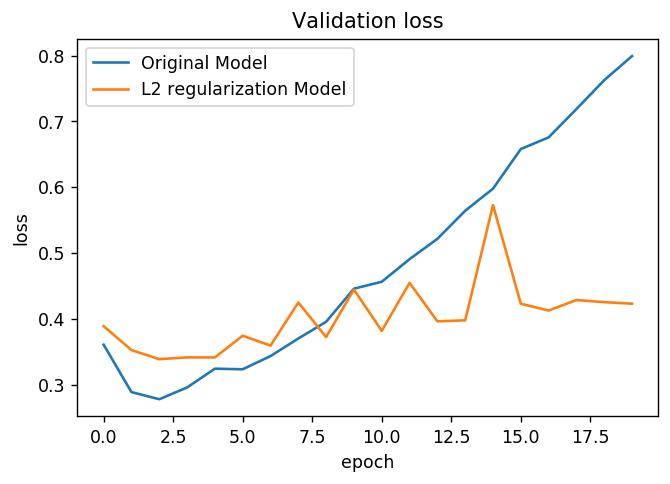

In [ ]:
plt.plot(original_hist.history['val_loss'])
plt.plot(l2_model_hist.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original Model', 'L2 regularization Model'], loc='upper left')
plt.show()

The loss of the original model is increasing with increase in the no.of epcohs. But the loss in the l2 model is stable and is oscillating around 0.3 to 0.4. The l2 model is performing better than the original model.

### Regularization: dropout
* One of the most effective and commonly used regularization techniques
* Randomly set a number of outputs of the layer to 0
* Idea: break up accidental non-significant learned patterns 
* _Dropout rate_: fraction of the outputs that are zeroed-out
    - Usually between 0.2 and 0.5
* At test time, nothing is dropped out, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training
* In Keras: add `Dropout` layers between the normal layers

In [ ]:
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               
                               batch_size=512, verbose=2,
                               validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.5959 - acc: 0.6858 - val_loss: 0.4566 - val_acc: 0.8593
Epoch 2/20
 - 3s - loss: 0.4475 - acc: 0.8118 - val_loss: 0.3531 - val_acc: 0.8732
Epoch 3/20
 - 3s - loss: 0.3570 - acc: 0.8630 - val_loss: 0.2953 - val_acc: 0.8877
Epoch 4/20
 - 3s - loss: 0.2993 - acc: 0.8922 - val_loss: 0.2751 - val_acc: 0.8908
Epoch 5/20
 - 3s - loss: 0.2595 - acc: 0.9083 - val_loss: 0.2784 - val_acc: 0.8898
Epoch 6/20
 - 3s - loss: 0.2272 - acc: 0.9215 - val_loss: 0.2893 - val_acc: 0.8874
Epoch 7/20
 - 3s - loss: 0.2026 - acc: 0.9325 - val_loss: 0.3045 - val_acc: 0.8874
Epoch 8/20
 - 3s - loss: 0.1843 - acc: 0.9385 - val_loss: 0.3250 - val_acc: 0.8818
Epoch 9/20
 - 3s - loss: 0.1665 - acc: 0.9440 - val_loss: 0.3426 - val_acc: 0.8822
Epoch 10/20
 - 3s - loss: 0.1559 - acc: 0.9478 - val_loss: 0.3625 - val_acc: 0.8805
Epoch 11/20
 - 3s - loss: 0.1458 - acc: 0.9509 - val_loss: 0.3837 - val_acc: 0.8802
Epoch 12/20
 - 3s - loss: 0.1360 - 

1. Plot the validation loss for the original and dropout models. How does the dropout model behave compared to the original?

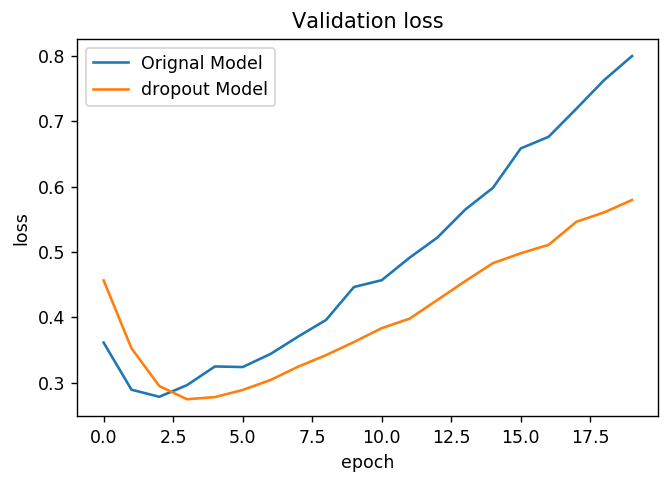

In [ ]:
plt.plot(original_hist.history['val_loss'])
plt.plot(dpt_model_hist.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Orignal Model', 'dropout Model'], loc='upper left')
plt.show()

The loss of both the original and dropout models are increasing with increase in the no.of epochs. But the dropout model is not overfitting.

### Regularization recap
* Get more training data
* Reduce the capacity of the network
* Add weight regularization
* Add dropout
* Either start with a simple model and add capacity
* Or, start with a complex model and then regularize by adding weight regularization and dropout

### Regression
* Dataset: 506 examples of houses and sale prices (Boston)
    - Included in Keras, with a 1/5 train-test split
* Each row is one house price, described by numeric properties of the house and neighborhood
* Small dataset, non-normalized features

In [ ]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


#### Preprocessing
* Neural nets work a lot better if we normalize the features first. 
* Keras has no built-in support so we have to do this manually (or with scikit-learn)
    - Again, be careful not to look at the test data during normalization
    


In [ ]:
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

#### Building the network
* This is a small dataset, so easy to overfit
    * We use 2 hidden layers of 64 units each
* Use smaller batches, more epochs
* Since we want scalar output, the output layer is one unit without activation
* Loss function is Mean Squared Error (bigger penalty)
* Evaluation metric is Mean Absolute Error (more interpretable)
* We will also use cross-validation, so we wrap the model building in a function, so that we can call it multiple times

1. Create a function build_model that returns the neural network model described above

In [ ]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Cross-validation
* Keras does not have support for cross-validation
* We can implement cross-validation ourselves (seeprovided code below)
* Alternatively, we can wrap a Keras model as a scikit-learn estimator
* Generally speaking, cross-validation is tricky with neural nets
    * Some fold may not converge, or fluctuate on random initialization
    

In [ ]:
# implementation of cross-validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 20
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=2)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


1. Train for longer (200 epochs) and keep track of loss after every epoch. Plot and describe the loss as a function of epoch number.

In [ ]:
from keras import backend as K
K.clear_session() # Memory clean-up

num_epochs = 200
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=2)
    mae_history = history.history['val_loss']
    all_mae_histories.append(mae_history)


processing fold # 0
Train on 303 samples, validate on 101 samples
Epoch 1/200
 - 0s - loss: 200.5871 - mean_absolute_error: 11.1427 - val_loss: 36.6219 - val_mean_absolute_error: 4.0493
Epoch 2/200
 - 0s - loss: 31.6524 - mean_absolute_error: 3.8774 - val_loss: 23.2317 - val_mean_absolute_error: 3.1690
Epoch 3/200
 - 0s - loss: 23.2053 - mean_absolute_error: 3.2575 - val_loss: 18.8090 - val_mean_absolute_error: 2.6417
Epoch 4/200
 - 0s - loss: 19.3499 - mean_absolute_error: 2.9204 - val_loss: 16.0620 - val_mean_absolute_error: 2.7144
Epoch 5/200
 - 0s - loss: 17.6967 - mean_absolute_error: 2.7737 - val_loss: 17.1859 - val_mean_absolute_error: 2.5788
Epoch 6/200
 - 0s - loss: 17.7099 - mean_absolute_error: 2.7062 - val_loss: 18.2660 - val_mean_absolute_error: 2.6572
Epoch 7/200
 - 0s - loss: 16.2255 - mean_absolute_error: 2.5966 - val_loss: 14.3685 - val_mean_absolute_error: 2.4345
Epoch 8/200
 - 0s - loss: 15.2492 - mean_absolute_error: 2.5131 - val_loss: 12.5098 - val_mean_absolute_e

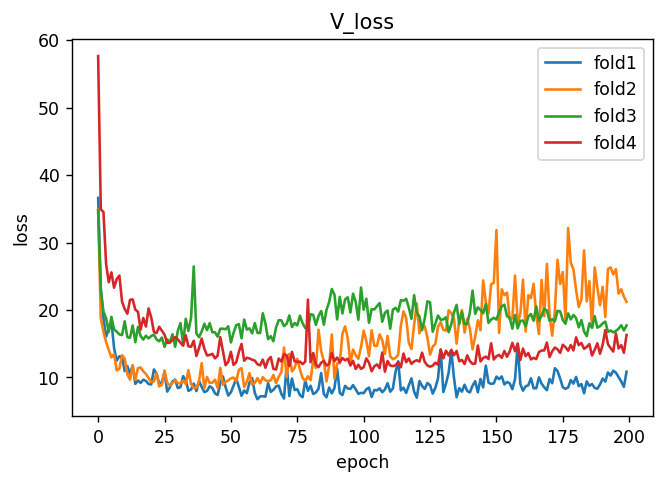

In [ ]:
plt.plot(all_mae_histories[0])
plt.plot(all_mae_histories[1])
plt.plot(all_mae_histories[2])
plt.plot(all_mae_histories[3])
plt.title('V_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['fold1', 'fold2', 'fold3', 'fold4'], loc = 'upper right')
plt.show()

Initially the loss of all the fields decreases drastically, later it seems to be oscillating between a certain range, not too high or low. Except fold2, the loss of other folds change less. Fold2 oscillates more than others. Compared to all the other folds, fold1 has the best loss.

#### Takeaways
* Regression is usually done using MSE loss and MAE for evaluation
* Input data should always be scaled (independent from the test set)
* Small datasets:
    - Use cross-validation
    - Use simple (non-deep) networks
    - Smaller batches, more epochs